In [17]:
import os
import random
import time
import collections
import torch
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import dgl

from innvariant_dgl.deepgg import DeepGG
from scipy.stats import entropy
from innvariant_dgl.dataset import ConstructionSequenceDataset, graph_to_construction_sequence, construction_sequence_to_graph
from innvariant_dgl.dataset import generate_ba_model_construction_sequence
from innvariant_dgl.dataset import generate_ws_model_construction_sequence
from innvariant_dgl.dataset import generate_er_model_construction_sequence
from tqdm import tqdm

# E-1-order: learning the same model from different construction sequences

Lets create a dataset with the different construction possibilities:

In [2]:
ba_num_nodes = 50
ba_m = 3
print('Generating a construction sequences from the Barabasi-Albert process')
ds_ba_process = ConstructionSequenceDataset([generate_ba_model_construction_sequence(ba_num_nodes, ba_m) for _ in range(5000)])
print('Generating a construction sequences from bfs-search of an Barabasi-Albert generated graph')
ds_ba_bfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.barabasi_albert_graph(ba_num_nodes, ba_m), traversal='bfs') for _ in range(5000)])
print('Generating a construction sequences from dfs-search of an Barabasi-Albert generated graph')
ds_ba_dfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.barabasi_albert_graph(ba_num_nodes, ba_m), traversal='dfs') for _ in range(5000)])
print('Done')

Generating a construction sequences from the Barabasi-Albert process
Generating a construction sequences from bfs-search of an Barabasi-Albert generated graph
Generating a construction sequences from dfs-search of an Barabasi-Albert generated graph
Done


In [3]:
ws_num_nodes = 50
ws_k = 3
ws_p = 0.1
print('Generating a construction sequences from the Barabasi-Albert process')
ds_ws_process = ConstructionSequenceDataset([generate_ws_model_construction_sequence(ws_num_nodes, ws_k, ws_p) for _ in range(5000)])
print('Generating a construction sequences from bfs-search of an Barabasi-Albert generated graph')
ds_ws_bfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.watts_strogatz_graph(ws_num_nodes, ws_k, ws_p), traversal='bfs') for _ in range(5000)])
print('Generating a construction sequences from dfs-search of an Barabasi-Albert generated graph')
ds_ws_dfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.watts_strogatz_graph(ws_num_nodes, ws_k, ws_p), traversal='dfs') for _ in range(5000)])
print('Done')

Generating a construction sequences from the Barabasi-Albert process
Generating a construction sequences from bfs-search of an Barabasi-Albert generated graph
Generating a construction sequences from dfs-search of an Barabasi-Albert generated graph
Done


In [4]:
er_num_nodes = 50
er_p = 0.1
print('Generating a construction sequences from the Erdos-Renyi process')
ds_er_process = ConstructionSequenceDataset([generate_er_model_construction_sequence(er_num_nodes, er_p) for _ in range(5000)])
print('Generating a construction sequences from bfs-search of an Erdos-Renyi generated graph')
ds_er_bfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.gnp_random_graph(er_num_nodes, er_p), traversal='bfs') for _ in range(5000)])
print('Generating a construction sequences from dfs-search of an Erdos-Renyi generated graph')
ds_er_dfs = ConstructionSequenceDataset([graph_to_construction_sequence(nx.gnp_random_graph(er_num_nodes, er_p), traversal='dfs') for _ in range(5000)])
print('Done')

Generating a construction sequences from the Erdos-Renyi process
Generating a construction sequences from bfs-search of an Erdos-Renyi generated graph
Generating a construction sequences from dfs-search of an Erdos-Renyi generated graph
Done


In [5]:
datasets = {
    'ba_process': ds_ba_process,
    'ba_bfs': ds_ba_bfs,
    'ba_dfs': ds_ba_dfs,
    'ws_process': ds_ws_process,
    'ws_bfs': ds_ws_bfs,
    'ws_dfs': ds_ws_dfs,
    'er_process': ds_er_process,
    'er_bfs': ds_er_bfs,
    'er_dfs': ds_er_dfs,
}

A quick plotting utility for counters, which we are going to use to plot histograms:

In [6]:
def plot_count(count: collections.Counter, title='', label=''):
    deg, cnt = zip(*count.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title('Histogram %s' % title)
    plt.ylabel('Count')
    plt.xlabel(label)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

Now lets have a look into the 

In [7]:
length_counter = {name: collections.Counter() for name in datasets}

lengths = {name: [len(seq) for seq in datasets[name]] for name in datasets}
for ds_name in length_counter:
    length_counter[ds_name].update(lengths[ds_name])

agg_ops = [np.mean, np.std, np.max, np.min, np.median]


print('Dataset lengths:')
for name in datasets:
    print(name, len(datasets[name]))
    print('Length distribution in construction sequences:')
    for agg in agg_ops:
        print(agg.__name__, agg(lengths[name]))
    print()

Dataset lengths:
ba_process 5000
Length distribution in construction sequences:
mean 473.0
std 0.0
amax 473
amin 473
median 473.0

ba_bfs 5000
Length distribution in construction sequences:
mean 609.8332
std 4.2465724720061
amax 616
amin 586
median 610.0

ba_dfs 5000
Length distribution in construction sequences:
mean 615.9886
std 0.1845807140521457
amax 616
amin 613
median 616.0

ws_process 5000
Length distribution in construction sequences:
mean 229.9268
std 12.56860540235073
amax 284
amin 200
median 230.0

ws_bfs 5000
Length distribution in construction sequences:
mean 336.6934
std 5.570547229850941
amax 343
amin 310
median 340.0

ws_dfs 5000
Length distribution in construction sequences:
mean 338.251
std 4.735863068121797
amax 343
amin 313
median 340.0

er_process 5000
Length distribution in construction sequences:
mean 417.113
std 31.991840068992595
amax 527
amin 311
median 416.0

er_bfs 5000
Length distribution in construction sequences:
mean 550.96
std 32.045879610333685
amax 68

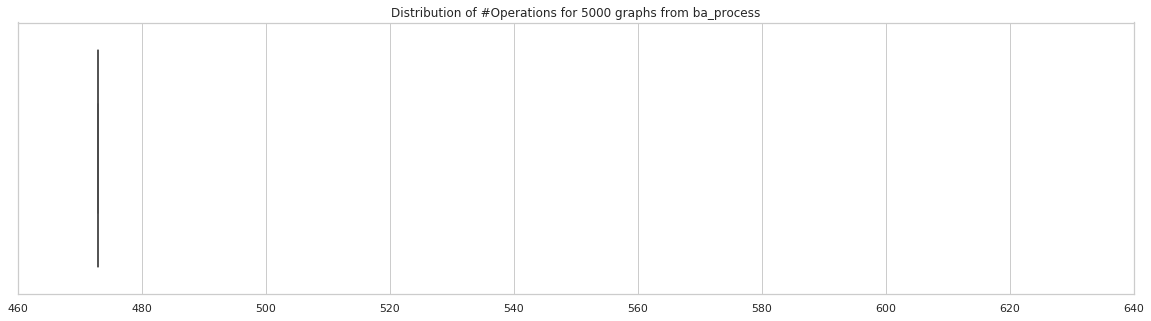

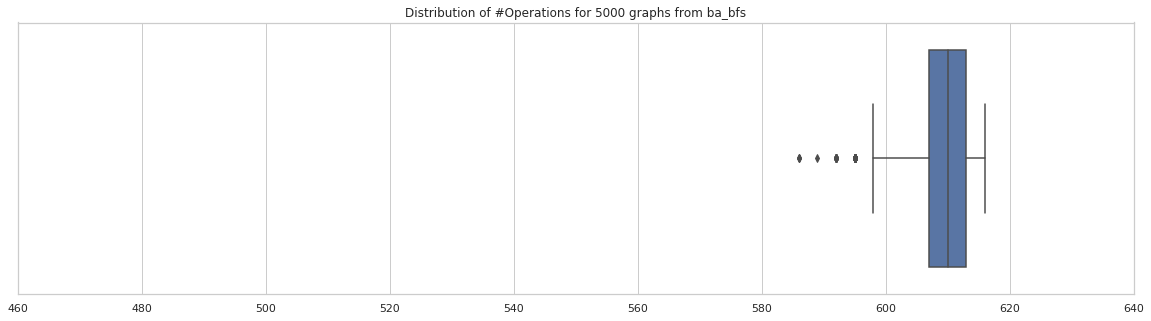

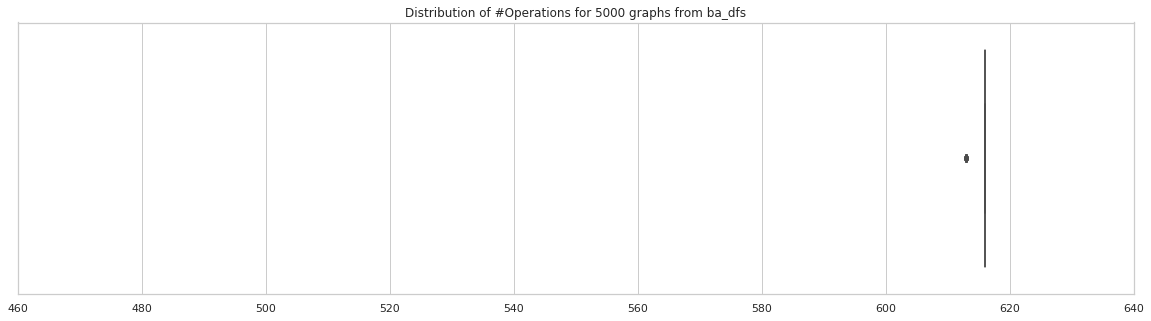

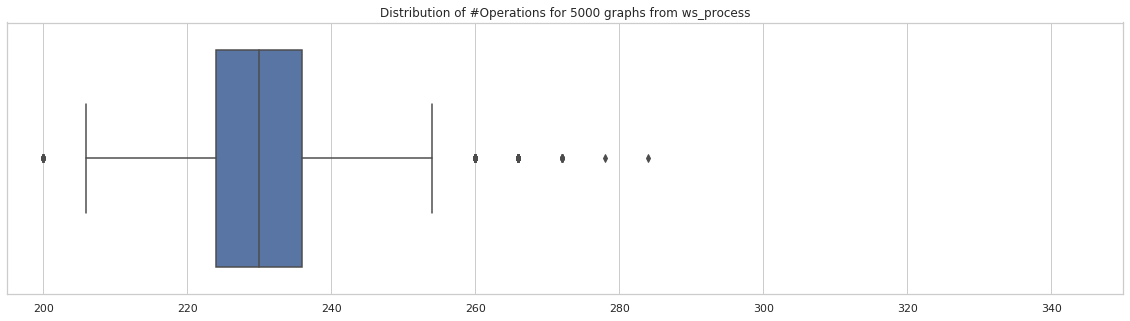

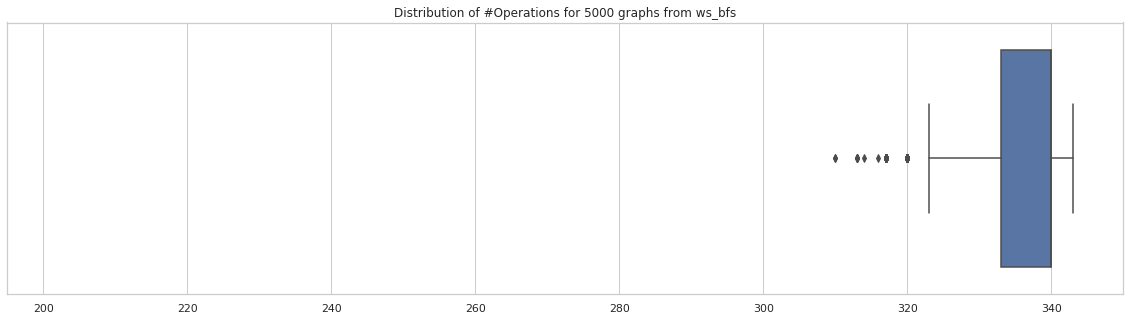

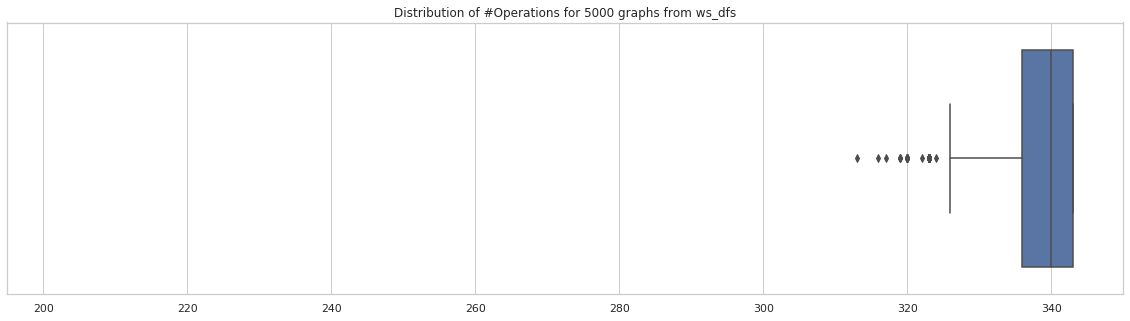

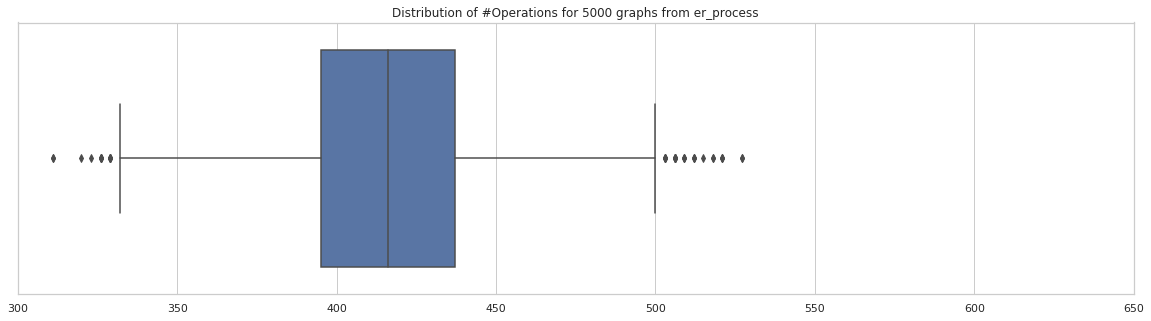

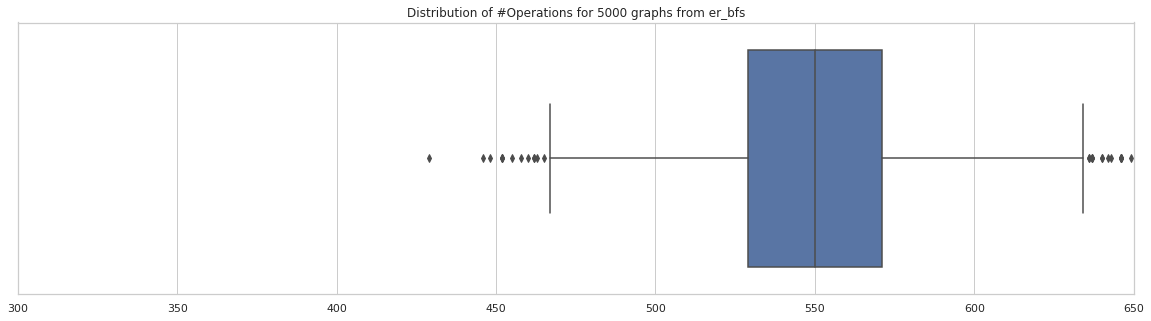

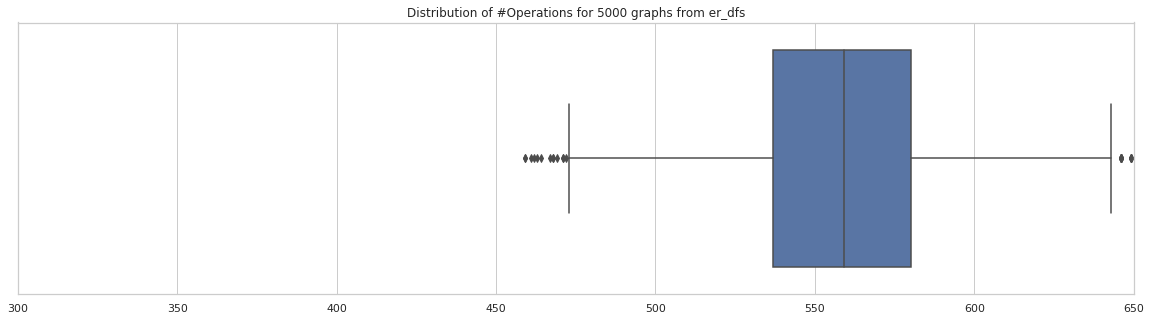

In [33]:
sns.set(style="whitegrid")

for name in datasets:
    plt.figure(figsize=(20,5))
    ax = sns.boxplot(lengths[name])
    if 'er_' in name:
        ax.set(xlim=(300, 650))
    elif 'ba_' in name:
        ax.set(xlim=(460, 640))
    elif 'ws_' in name:
        ax.set(xlim=(195, 350))
    ax.set_title('Distribution of #Operations for {num} graphs from {name}'.format(num=len(datasets[name]), name=name))
    plt.show()

Now we are looking into the degree histogram/distribution of the generated sequences by transforming them into graphs and collect their degrees (of the whole graph).

In [66]:
def count_degree(ds_construction_sequence):
    degree_count = collections.Counter()

    for cur_graph in [construction_sequence_to_graph(seq) for seq in ds_construction_sequence]:
        degree_sequence = sorted([d for n, d in cur_graph.degree()], reverse=True)
        degree_count.update(degree_sequence)
    return degree_count

counter_degree = {name: count_degree(datasets[name]) for name in datasets}

ba_process


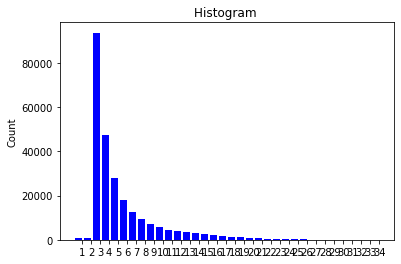

ba_bfs


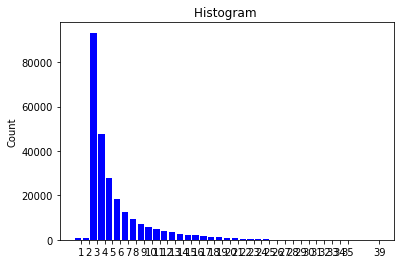

ba_dfs


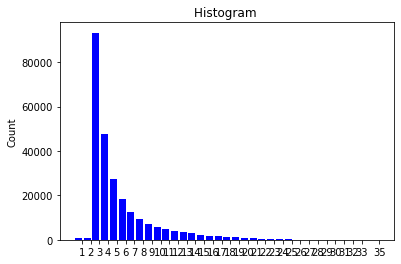

ws_process


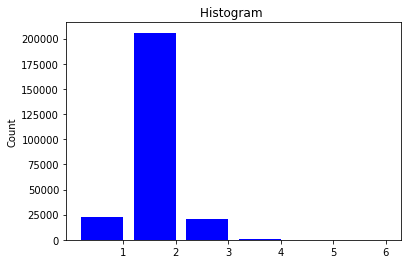

ws_bfs


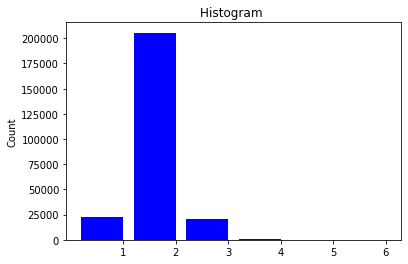

ws_dfs


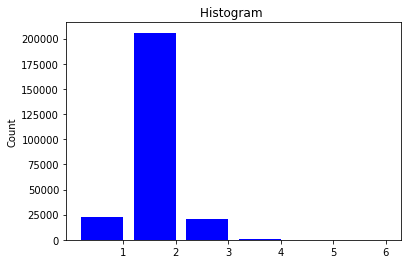

In [67]:
for name in datasets:
    print(name)
    plot_count(counter_degree[name])

Utility function to compute a kullback leibler divergence between distributions:

In [68]:
def kl_divergence(p, q):    
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

Now let's extract the histograms (counts) of the degree in the same order (ascending degree number) for both the Barabasi-Albert-process and the BFS-approach:

In [70]:
any_dataset_name = next(iter(datasets.keys()))
degrees_sorted = sorted([d for d in sorted(counter_degree[any_dataset_name])])

degree_histograms = {name: [counter_degree[name].get(d) if counter_degree[name].get(d) is not None else 0 for d in degrees_sorted] for name in datasets}
degree_histograms = {name: np.array(list(degree_histograms[name])) for name in degree_histograms}

for name in datasets:
    print(name)
    print(degree_histograms[name])
    print()

ba_process
[  604   723 93558 47440 27882 17998 12527  9426  7155  5649  4629  3957
  3307  2947  2399  2036  1618  1376  1208   900   732   581   414   307
   232   150    97    58    37    23    18     8     3     1]

ba_bfs
[  640   728 93252 47515 27750 18277 12700  9363  7233  5644  4658  3859
  3351  2817  2360  2013  1750  1376  1101   956   756   570   405   317
   204   133   112    68    36    25    11    10     4     3]

ba_dfs
[  598   700 93301 47627 27412 18391 12658  9297  7219  5811  4682  4013
  3383  2886  2334  1931  1744  1379  1132   950   688   541   413   337
   208   133    70    70    43    27    15     3     3     0]

ws_process
[ 22604 205863  20501    994     37      1      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]

ws_bfs
[ 22776 205524  20675    975     49      1      0      0      0      0
      0      0 

In [71]:
for name in datasets:
    print(name)
    for agg in [np.mean, np.std, np.median, np.max, np.min]:
        print(agg.__name__, round(agg(degree_histograms[name]), 2))
    print()

ba_process
mean 7352.94
std 17716.01
median 1054.0
amax 93558
amin 1

ba_bfs
mean 7352.85
std 17679.58
median 1028.5
amax 93252
amin 3

ba_dfs
mean 7352.91
std 17684.7
median 1041.0
amax 93301
amin 0

ws_process
mean 7352.94
std 34925.79
median 0.0
amax 205863
amin 0

ws_bfs
mean 7352.94
std 34873.31
median 0.0
amax 205524
amin 0

ws_dfs
mean 7352.94
std 34931.36
median 0.0
amax 205898
amin 0



With this histograms we can compute their kullback-leibler divergence and the entropy from the scipy stats module:

In [72]:
for (n1, h1), (n2, h2) in itertools.combinations([(n, degree_histograms[n]) for n in degree_histograms], 2):
    print(n1, n2)
    print(h1)
    print(h2)
    print('KL-divergence', kl_divergence(h2, h1))
    degree_entropy = entropy(pk=h2, qk=h1)
    print('Entropy', degree_entropy)
    print('Degree entropy sufficient small?', degree_entropy < 0.001)
    print()

ba_process ba_bfs
[  604   723 93558 47440 27882 17998 12527  9426  7155  5649  4629  3957
  3307  2947  2399  2036  1618  1376  1208   900   732   581   414   307
   232   150    97    58    37    23    18     8     3     1]
[  640   728 93252 47515 27750 18277 12700  9363  7233  5644  4658  3859
  3351  2817  2360  2013  1750  1376  1101   956   756   570   405   317
   204   133   112    68    36    25    11    10     4     3]
KL-divergence 28.518676851881633
Entropy 0.00012607614832095543
Degree entropy sufficient small? True

ba_process ba_dfs
[  604   723 93558 47440 27882 17998 12527  9426  7155  5649  4629  3957
  3307  2947  2399  2036  1618  1376  1208   900   732   581   414   307
   232   150    97    58    37    23    18     8     3     1]
[  598   700 93301 47627 27412 18391 12658  9297  7219  5811  4682  4013
  3383  2886  2334  1931  1744  1379  1132   950   688   541   413   337
   208   133    70    70    43    27    15     3     3     0]
KL-divergence 42.868483957032

/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/media/data/anaconda3/envs/sur-inn02-deep-graph-learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


The Kullback-Leibler divergence is low (compared to the summed values), thus meaning that the distributions are very similar.
When our entropy is basically zero, we have (most likely) equal distributions.
This should be no surprise, because we sampled twice from a random model for generating graphs which have a distinct degree distribution.

In [73]:
first_models_base_path = '/media/data/computations/inn02-deep-graph-learning/first-models/'

def get_model(path, minimum_vertices=50, max_v=100, node_hidden_size=16, num_prop_rounds=2):
    device = 'cpu'
    model = DeepGG(v_max=max_v, node_hidden_size=node_hidden_size, num_prop_rounds=num_prop_rounds)
    model.v_min = minimum_vertices
    pretrained_model_state = torch.load(path)
    model.load_state_dict(pretrained_model_state)
    model.to(device)
    model.eval()  # important: set model to inference mode
    return model

In [74]:
one_model_file = 'deepgg-model-t1588681161.pth'
trained_model_path = os.path.join(first_models_base_path, one_model_file)
one_model = get_model(trained_model_path)

How many parameters does our model have?

In [75]:
sum(p.numel() for p in one_model.parameters() if p.requires_grad)

10271

Now let's sample one single graph from the model:

In [77]:
test_empty_graph = dgl.DGLGraph()
test_empty_graph.to(device)
graph, seq = one_model.forward(test_empty_graph)
print(graph)
print(seq)

DGLGraph(num_nodes=101, num_edges=269,
         ndata_schemes={'dgg_hv': Scheme(shape=(16,), dtype=torch.float32), 'dgg_a': Scheme(shape=(32,), dtype=torch.float32)}
         edata_schemes={'dgg_he': Scheme(shape=(16,), dtype=torch.float32)})
[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 1, 3, 1, 0, 1, 0, 3, 1, 3, 2, 0, 1, 2, 0, 1, 4, 4, 1, 5, 5, 0, 1, 0, 5, 1, 2, 5, 1, 5, 6, 0, 1, 5, 4, 1, 7, 0, 0, 1, 1, 7, 1, 2, 7, 1, 0, 8, 0, 1, 1, 0, 1, 4, 1, 0, 1, 8, 10, 1, 9, 5, 1, 6, 8, 0, 1, 2, 6, 1, 10, 9, 1, 1, 11, 0, 1, 0, 11, 1, 6, 5, 0, 1, 10, 0, 1, 7, 11, 0, 1, 8, 4, 1, 1, 13, 0, 1, 2, 14, 1, 13, 14, 1, 3, 15, 0, 1, 14, 16, 1, 14, 9, 0, 1, 12, 9, 1, 0, 14, 1, 16, 1, 1, 13, 4, 0, 1, 0, 12, 1, 0, 9, 1, 4, 8, 1, 5, 12, 0, 0, 1, 11, 5, 1, 17, 11, 0, 1, 19, 9, 1, 6, 18, 0, 1, 19, 21, 1, 1, 20, 1, 11, 11, 0, 1, 15, 19, 0, 1, 21, 23, 1, 22, 23, 1, 17, 14, 0, 1, 15, 9, 1, 20, 23, 1, 22, 24, 1, 8, 19, 0, 1, 5, 25, 1, 9, 18, 1, 5, 16, 1, 4, 25, 0, 1, 1, 12, 1, 26, 10, 1, 21, 15, 1, 23, 13, 0, 1, 17, 1, 1

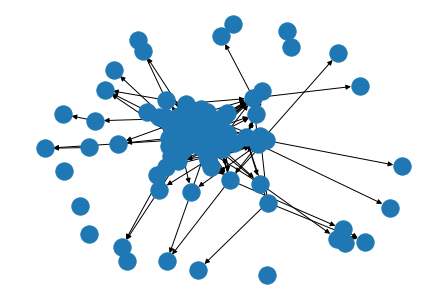

In [78]:
nx.draw(graph.to_networkx())

In [79]:
# Trained on barabasi-albert-bfs-100-3
model_ba_bfs_100_3 = get_model('deepgg-model-t1589212757.pth')

In [80]:
def generate(model: DeepGG, num_graphs=100):
    model.eval()
    sequences = []
    graphs = []
    for _ in range(num_graphs):
        empty_graph = dgl.DGLGraph()
        empty_graph.to(device)
        graph, seq = model.forward(empty_graph)
        sequences.append(seq)
        graphs.append(graph.to_networkx())
    return graphs, sequences

In [81]:
gen_one_model_result = generate(one_model)

In [82]:
gen_one_model_graphs, gen_one_model_seqs = gen_one_model_result

100

In [84]:
len(gen_one_model_graphs)

100

In [83]:
gen_model_ba_bfs_100_3_result = generate(model_ba_bfs_100_3)

In [86]:
gen_model_ba_bfs_100_3_graphs, gen_model_ba_bfs_100_3_seqs = gen_model_ba_bfs_100_3_result
len(gen_model_ba_bfs_100_3_graphs)

100

# Degree distributions of complex network types
We look into the degree distributions of graphs generated from probabilistic, parameterized models ("Random Graph Generators" RGG) and our generative models (DeepGG) for graphs learned from examples of those probabilistic models.

In [87]:
def count_graphs_degree(graph_list: list):
    degree_count = collections.Counter()

    for graph in graph_list:
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
        degree_count.update(degree_sequence)
    return degree_count

def graph_degree_counter_to_histogram(counter_degree: collections.Counter, degrees_sorted: list=None):
    if degrees_sorted is None:
        degrees_sorted = sorted([d for d in sorted(counter_degree)])
        
    return [counter_degree.get(d) if counter_degree.get(d) is not None else 0 for d in degrees_sorted]

def get_degree_histogram(graph_list: list, degrees_sorted: list=None):
    counter_degree = count_graphs_degree(graph_list)

    return graph_degree_counter_to_histogram(counter_degree(graph_list), degrees_sorted)

In [88]:
drogon_base_path = '/media/data/computations/inn02-deep-graph-learning/drogon/'
drogon_first_model_prefix = 'deepgg-t1589299685-'
drogon_first_used_dataset = os.path.join(drogon_base_path, drogon_first_model_prefix + 'ds-1000-generate_seqs_barabasi_albert_dfs.json')
drogon_first_generated = os.path.join(drogon_base_path, drogon_first_model_prefix + 'generated-generate_seqs_barabasi_albert_dfs.json')
drogon_first_metadata = os.path.join(drogon_base_path, drogon_first_model_prefix + 'metadata-generate_seqs_barabasi_albert_dfs.json')
drogon_first_model = os.path.join(drogon_base_path, drogon_first_model_prefix + 'model-generate_seqs_barabasi_albert_dfs.pth')

In [90]:
import json

In [91]:
with open(drogon_first_metadata, 'r') as mh:
    metadata = json.load(mh)
print(metadata)

{'start_time': 1589299685.7169487, 'params': {'param_train_epochs': 8, 'param_learning_rate': 0.0001, 'param_deepgg_prop_rounds': 2, 'param_deepgg_v_max': 150, 'param_deepgg_node_hidden_size': 16, 'param_deepgg_generate_size': 200, 'param_deepgg_generate_v_min': 0, 'param_dataset_size': 1000, 'param_model_num_v': 50, 'param_model_num_v_min': 50, 'param_model_num_v_max': 50, 'param_model_er_p': 0.2, 'param_model_ws_k': 10, 'param_model_ws_p': 0.2, 'param_model_ba_m': 3, 'param_selected_model': 'generate_seqs_barabasi_albert_dfs'}, 'hyperparams': {'hp_deepgg_generate_v_min_range': [0, 40, 10], 'hp_dataset_size_range': [500, 2001, 500], 'hp_model_num_v_min_range': [20, 50, 5], 'hp_model_num_v_max_range': [50, 151, 10], 'hp_model_er_p_range': [0.1, 0.9, 0.2], 'hp_model_ws_k_range': [3, 12, 1], 'hp_model_ws_p_range': [0.1, 0.9, 0.2], 'hp_model_ba_m_range': [2, 9, 1]}, 'files': {'dataset_file_name': 'deepgg-t1589299685-ds-1000-generate_seqs_barabasi_albert_dfs.json', 'dataset_file_path': 'da

In [99]:
with open(drogon_first_used_dataset, 'r') as dd:
    used_ds_data = json.load(dd)
used_ds = used_ds_data['construction_sequences']

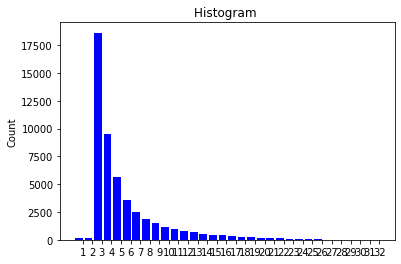

In [100]:
used_ds_graphs = [construction_sequence_to_graph(seq) for seq in used_ds]
plot_count(count_graphs_degree(used_ds_graphs))

In [94]:
with open(drogon_first_generated, 'r') as mg:
    generated = json.load(mg)
ds_gen = generated['construction_sequences']

In [96]:
ds_gen_graphs = [construction_sequence_to_graph(seq) for seq in ds_gen]

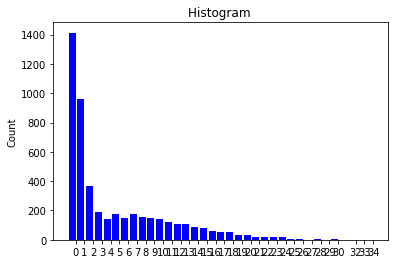

In [97]:
plot_count(count_graphs_degree(ds_gen_graphs))

# Look into ready computed generative models

In [107]:
drogon_base_path = '/media/data/computations/inn02-deep-graph-learning/drogon/'

drogon_generated_files = []
for filename in os.listdir(drogon_base_path):
    if "generated" in filename and filename.endswith(".json") and os.path.getsize(os.path.join(drogon_base_path, filename)) > 0:
        drogon_generated_files.append(filename)

deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json


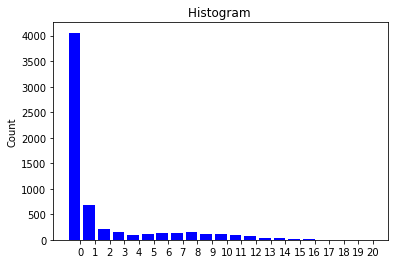

deepgg-t1589299685-generated-generate_seqs_barabasi_albert_dfs.json


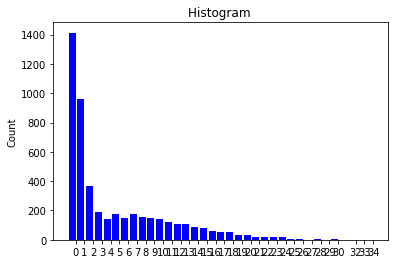

deepgg-t1589299796-generated-generate_seqs_erdos_renyi_bfs.json


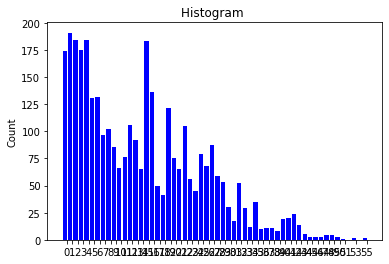

deepgg-t1589299418-generated-generate_seqs_erdos_renyi_dfs.json


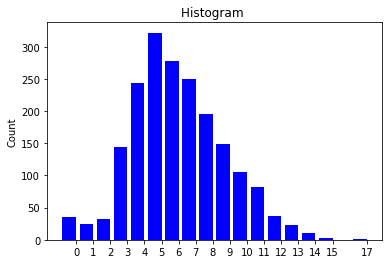

deepgg-t1589299414-generated-generate_seqs_erdos_renyi_dfs.json


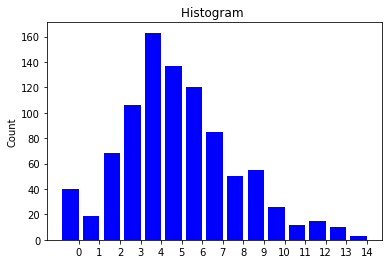

deepgg-t1589299411-generated-generate_seqs_watts_strogatz_dfs.json


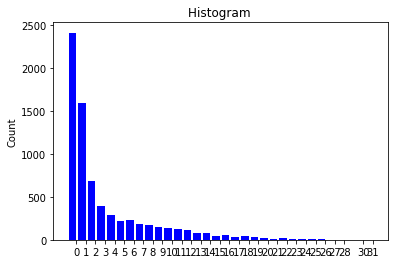

deepgg-t1589299334-generated-generate_seqs_erdos_renyi_bfs.json


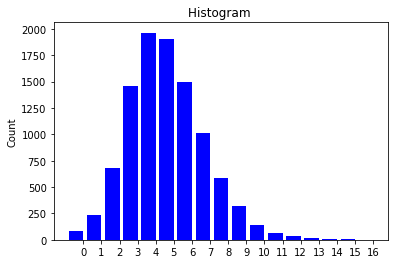

In [108]:
for filename in drogon_generated_files:
    with open(os.path.join(drogon_base_path, filename), 'r') as dd:
        data_generated = json.load(dd)
    generated_cs = data_generated['construction_sequences']
    generated_graphs = [construction_sequence_to_graph(seq) for seq in generated_cs]
    print(filename)
    plot_count(count_graphs_degree(generated_graphs))

deepgg-t1589299334-ds-1000-generate_seqs_erdos_renyi_bfs.json


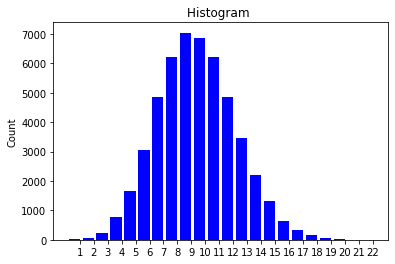

In [35]:
gen_one_model_deg_counter = count_graphs_degree(gen_one_model_graphs)
gen_model_ba_bfs_100_3_deg_counter = count_graphs_degree(gen_model_ba_bfs_100_3_graphs)

gen_one_model_deg_hist = graph_degree_counter_to_histogram(gen_one_model_deg_counter)
gen_model_ba_bfs_100_3_deg_hist = graph_degree_counter_to_histogram(gen_model_ba_bfs_100_3_deg_counter)

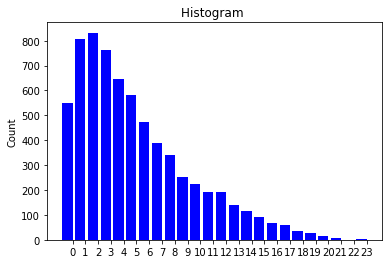

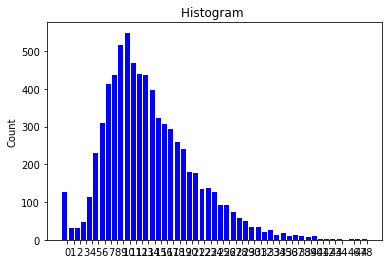

In [38]:
plot_count(gen_one_model_deg_counter)
plot_count(gen_model_ba_bfs_100_3_deg_counter)

# How should distributions of the probabilistic models look like?

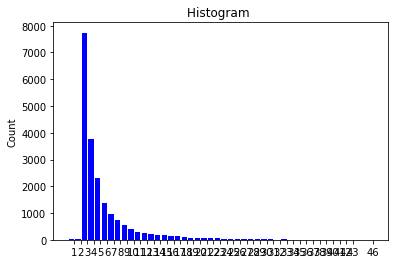

In [40]:
plot_count(count_graphs_degree([nx.barabasi_albert_graph(100, 3) for _ in range(200)]))

# Degree distributions of Erdos-Renyi

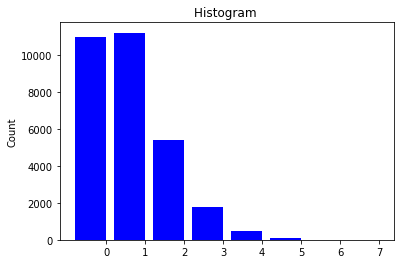

In [109]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.01) for _ in range(300)]))

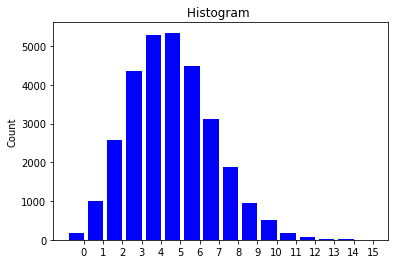

In [110]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.05) for _ in range(300)]))

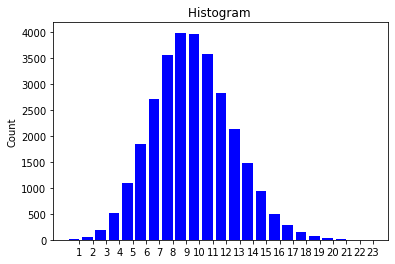

In [43]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.1) for _ in range(300)]))

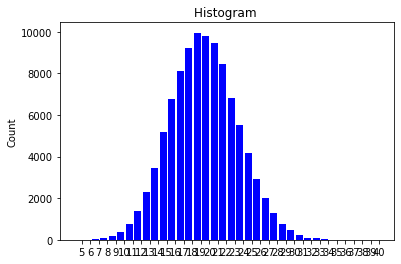

In [44]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.2) for _ in range(1000)]))

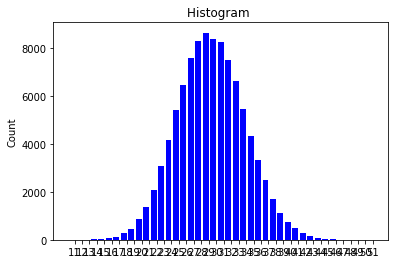

In [45]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.3) for _ in range(1000)]))

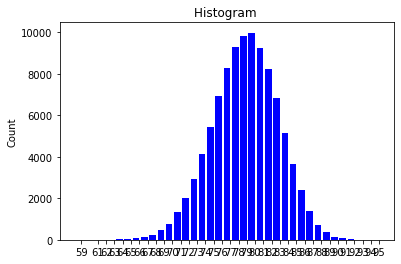

In [46]:
plot_count(count_graphs_degree([nx.erdos_renyi_graph(100, 0.8) for _ in range(1000)]))

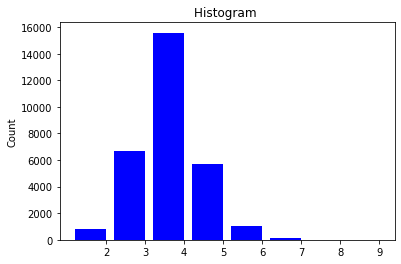

In [52]:
plot_count(count_graphs_degree([nx.watts_strogatz_graph(100, 4, 0.2) for _ in range(300)]))

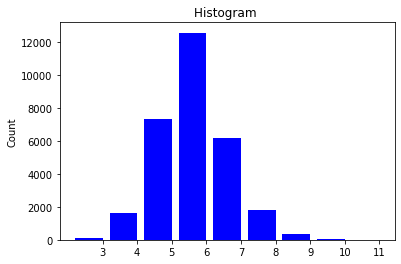

In [53]:
plot_count(count_graphs_degree([nx.watts_strogatz_graph(100, 6, 0.2) for _ in range(300)]))

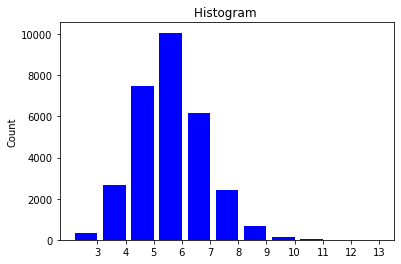

In [54]:
plot_count(count_graphs_degree([nx.watts_strogatz_graph(100, 6, 0.3) for _ in range(300)]))

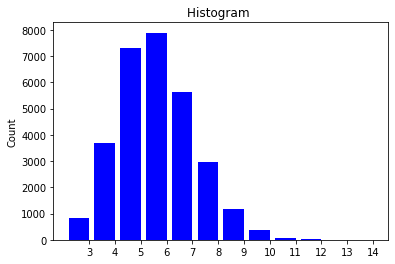

In [55]:
plot_count(count_graphs_degree([nx.watts_strogatz_graph(100, 6, 0.5) for _ in range(300)]))

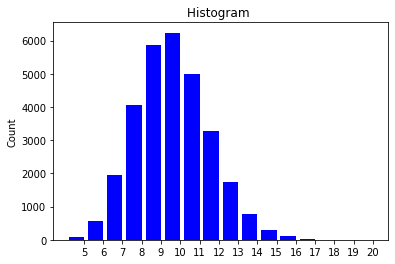

In [56]:
plot_count(count_graphs_degree([nx.watts_strogatz_graph(100, 10, 0.5) for _ in range(300)]))

# Compare ES-models and ER-learned generators

In [114]:
def plot_construction_sequences_degree_hist(filepath: str):
    with open(filepath, 'r') as dd:
        data_generated = json.load(dd)
    generated_cs = data_generated['construction_sequences']
    generated_graphs = [construction_sequence_to_graph(seq) for seq in generated_cs]
    plot_count(count_graphs_degree(generated_graphs))

## t1589299334 / bfs

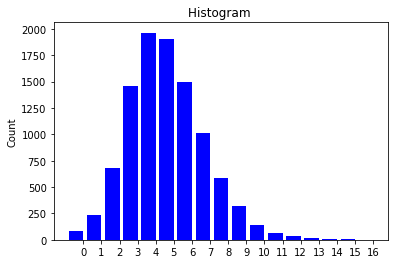

In [115]:
filename = 'deepgg-t1589299334-generated-generate_seqs_erdos_renyi_bfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

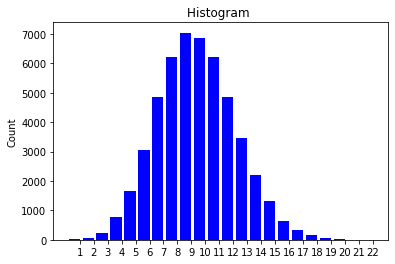

In [116]:
filename = 'deepgg-t1589299334-ds-1000-generate_seqs_erdos_renyi_bfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

## t1589299409 / dfs

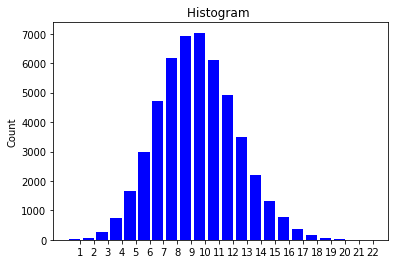

In [118]:
filename = 'deepgg-t1589299409-ds-1000-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

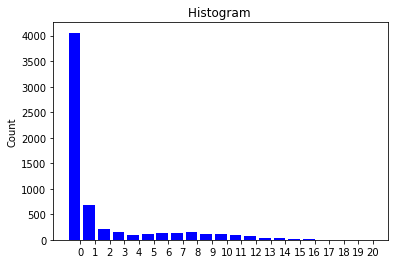

In [119]:
filename = 'deepgg-t1589299409-generated-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

## t1589299414 dfs

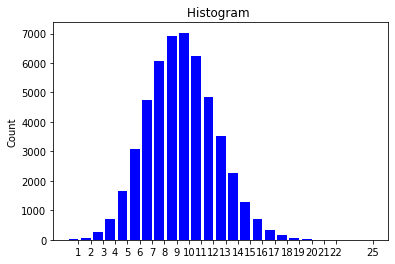

In [123]:
filename = 'deepgg-t1589299414-ds-1000-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

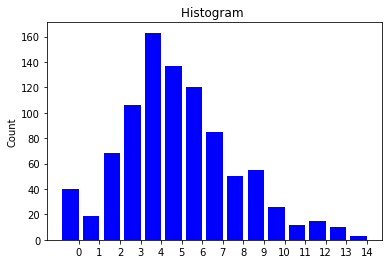

In [124]:
filename = 'deepgg-t1589299414-generated-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

## t1589299418 dfs

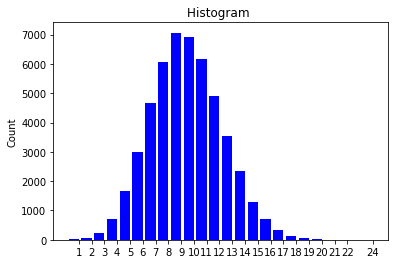

In [120]:
filename = 'deepgg-t1589299418-ds-1000-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

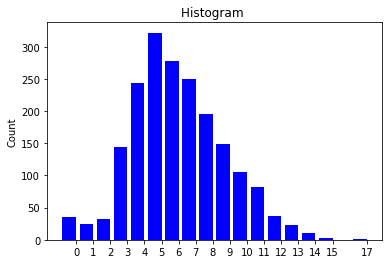

In [121]:
filename = 'deepgg-t1589299418-generated-generate_seqs_erdos_renyi_dfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

## t1589299796 bfs

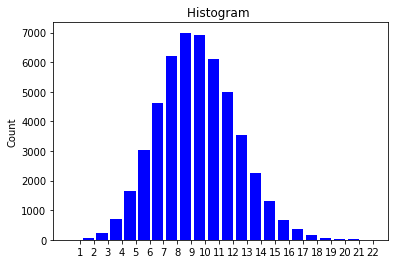

In [125]:
filename = 'deepgg-t1589299796-ds-1000-generate_seqs_erdos_renyi_bfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))

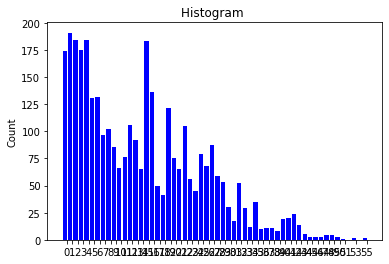

In [127]:
filename = 'deepgg-t1589299796-generated-generate_seqs_erdos_renyi_bfs.json'
plot_construction_sequences_degree_hist(os.path.join(drogon_base_path, filename))